# Natural Language Processing with Disaster Tweets


#### Description
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. 

Kaggle Competition: https://www.kaggle.com/c/nlp-getting-started/overview

## Research Questions:


1. Can K-nearest neighbors (KNN) algorithm be effectively applied to predict the classification of the tweets? 

2. What are the key similarities and differences between KNN and linear regression algorithms in this context, and how do they perform in terms of prediction accuracy, computational efficiency, and interpretability?

3. Which topics are most important or prevalent?

4. How is the distribution of location and keywords?


In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import plotly.graph_objects as go
import plotly.graph_objects as go

import seaborn as sns



In [53]:
data_train = pd.read_csv('train.csv')

In [54]:
data_test = pd.read_csv('test.csv')

In [55]:
data_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [56]:
data_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [57]:
data_train.shape

(7613, 5)

In [58]:
data_test.shape

(3263, 4)

In [59]:
data_train['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [60]:
data_train['location'].unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

In [61]:
data_train.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

### How many tweets talk about disasters 

In [62]:
value_counts = data_train['target'].value_counts()

fig = go.Figure(data=[go.Pie(
    labels=['Not talking about disasters', 'Talking about disasters'],
    values=value_counts,
    hole=0.4,  # Set the hole size for a donut chart effect
    marker=dict(colors=['#1f77b4', '#ff7f0e'])  # Customize the colors for each section
)])
fig.update_layout(
    title='Disaster Mention Distribution',
    title_x=0.5,  # Align the title to the center
    font=dict(size=16)  # Increase font size for readability
)
fig.show()


## Cleaning the data


In [63]:
print(data_train.duplicated())

0       False
1       False
2       False
3       False
4       False
        ...  
7608    False
7609    False
7610    False
7611    False
7612    False
Length: 7613, dtype: bool


In [64]:
data_train[data_train.isna().any(axis=1)]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


As many rows have Nans, the rows were not dropped

In [65]:
data_train.shape

(7613, 5)

Since only around a third of the data contains actual data in the columns 'Location' and 'Keyword', I have decided to drop them.


In [66]:
data_train = data_train.drop(['location'], axis=1)

In [67]:
data_train = data_train.drop(['keyword'], axis=1)

In [68]:
data_train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


## Text preprocessing

### KNN Model

### Chosing K-Nearest Neighbours

In this case, I have chosen the KNN (K-nearest neighbors) algorithm as the solution for the following reason: 

The algorithm matches samples based on the ones it has encountered during training. Considering the nature of tweets and the objective of classifying them as related to disasters or not, KNN is the most suitable choice. This is because KNN can leverage the use of figures of speech and the formulaic approach often employed by news outlets when discussing various types of disasters. This allows the algorithm to capture patterns and utilize them in categorizing the tweets. 


In [69]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [70]:
import string 

def preprocess_text(text):
    # Remove punctuations and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation)) # as suggested by ChatGPT
    # Convert to lowercase
    text = text.lower()
    # Remove single characters
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    # Lemmatize and remove stopwords
    text = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(text)

In [71]:
data_train['processed_text'] = data_train['text'].apply(preprocess_text)


In [72]:
X = data_train['processed_text']
y = data_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)


In [73]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [74]:
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)
data_test['processed_text'] = data_test['text'].apply(preprocess_text)
X_test_data = data_test['processed_text']
X_test_data = vectorizer.transform(X_test_data)
pred_knn_test = knn_clf.predict(X_test_data)

In [75]:
output_data = pd.DataFrame({'text': data_test['text'], 'prediction': pred_knn_test})
output_data.head()

,text,prediction
0,Just happened a terrible car crash,0
1,"Heard about #earthquake is different cities, s...",1
2,"there is a forest fire at spot pond, geese are...",0
3,Apocalypse lighting. #Spokane #wildfires,0
4,Typhoon Soudelor kills 28 in China and Taiwan,1


In [76]:
output_data.to_csv('predictions.csv', index=False)

### Evaluating the model

In [77]:
from sklearn.metrics import make_scorer, accuracy_score

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
pred_knn = knn_clf.predict(X_test)
acc_knn = accuracy_score(y_test, pred_knn)

print(acc_knn)

0.7774130006565988


### Can K-nearest neighbors (KNN) algorithm be effectively applied to predict the classification of the tweets? 

The evaluating Model achived a prediction accuracy of 77.74%, which can be considered reasonanably accurate, as the task was not very difficult.  

## Topic Modelling

In [78]:
df_topic_modelling = pd.concat([data_test, data_train], ignore_index=True)
df_topic_modelling =df_topic_modelling.drop('processed_text', axis=1)

In [79]:
df_topic_modelling.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,NaN
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",NaN
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",NaN
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,NaN
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,NaN


In [80]:
columns_to_drop = ['keyword', 'location','target','id']
df_topic_modelling=df_topic_modelling.drop(columns_to_drop, axis=1)

In [81]:
df_topic_modelling.head()

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


In [82]:
df_topic_modelling['processed_text'] = df_topic_modelling['text'].apply(preprocess_text)

### Chosing Non-Negative Matrix Factorization



In [83]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')


In [84]:
tfidf = tfidf_vectorizer.fit_transform(df_topic_modelling['processed_text'])


In [85]:
nmf = NMF(n_components=5, random_state=42)
nmf.fit(tfidf)

NMF(n_components=5, random_state=42)

In [86]:
feature_names = tfidf_vectorizer.get_feature_names_out()
for idx, topic in enumerate(nmf.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
    print("Topic", idx, " ".join(top_words))

Topic 0 http new video emergency body crash youtube reddit amp watch
Topic 1 like look feel amp people burning think got building mudslide
Topic 2 suicide bomber bomb old pkk detonated yr turkey army trench
Topic 3 family mh legionnaire malaysia confirmed wreckage pm conclusively investigator outbreak
Topic 4 california home northern wildfire latest razed news abc disaster obama


### Interpreting the topics

<b>Topic  0 http new video emergency reddit body crash youtube woman content </b>

The apperance of http right at the beginning of this topic suggests that this topic focuses on shared media, specifically linked media from other websites, such as YouTube and Reddit. This conclusion is also supported by the occurence of "new" and "content". Weather or not this topic points to desaster related content can not be certainly said. 
    
<b>Topic  1 family mh legionnaire malaysia wreckage confirmed pm conclusively investigator outbreak </b>

Topic 2 focusses on media stories, most likely regarding some sort of (disease) outbreak and a car accident happening to a malaysian family. The words "confirmed", "conclusively" and "pm" indicate the news coverage, while 

<b>Topic  2 like look feel amp people burning got building mudslide think </b>

The main focus of this topic could at first glance be a fire or a mudslide. However, the words "like" and look" actually suggest, that this topic covers a majority of the tweets, that do not focus on disasters but rather use these expressions to convey the authors feelings about a given situation. 
    
<b>Topic  3 california home wildfire northern latest razed news abc disaster obama </b>

This topic seems to talk clearly about the wildfires in the united states, specifically Carlifornia. The words "wildfire" and "carlifornia" are the most obvious indicators. This is further supported by the words "razed" and "disaster". "latest", news and "abc" further suggest intensive coverage on the news, which was either shared, or discussed in the tweets. Lastly, the 
    
<b>Topic  4 suicide bomb bomber old detonated pkk yr army turkey trench </b>

The forth Topic seems to be related to armed conflicts and terrorist activities. 




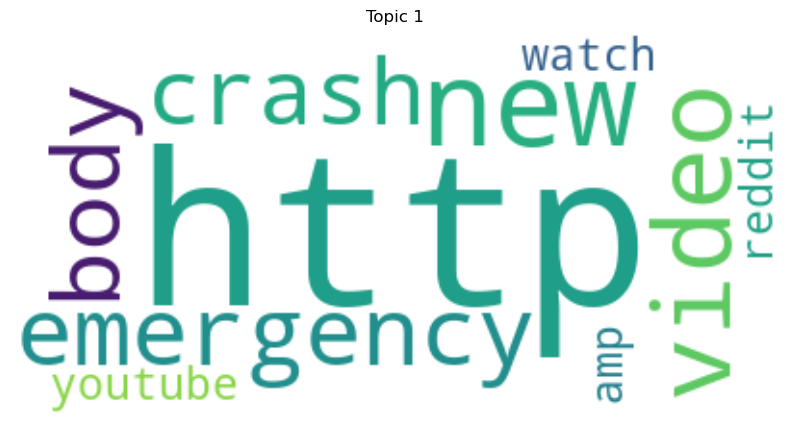

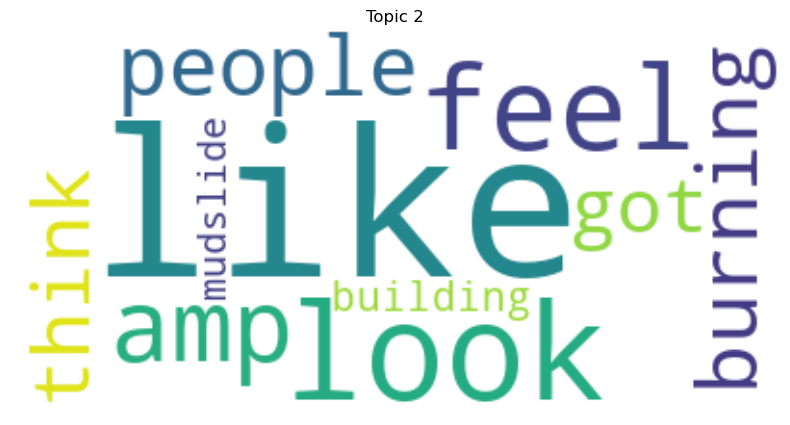

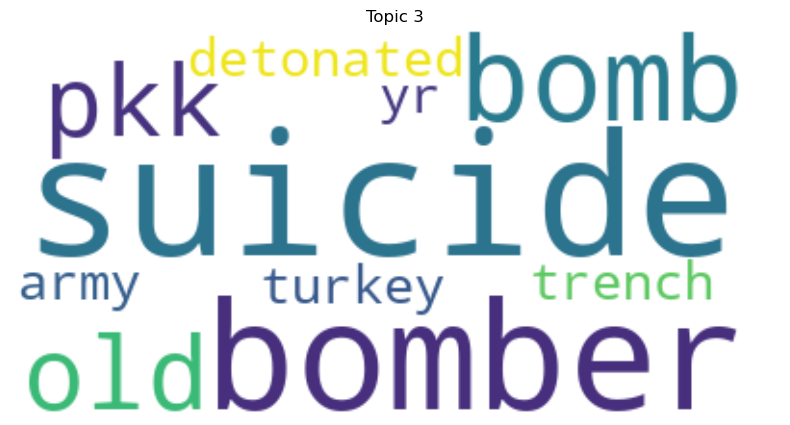

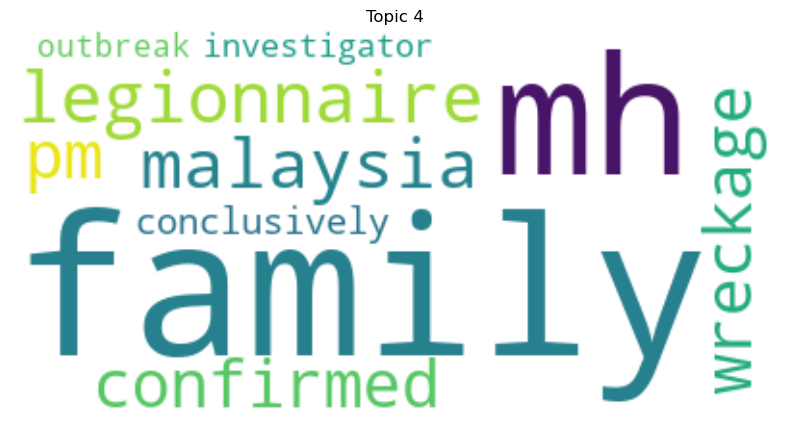

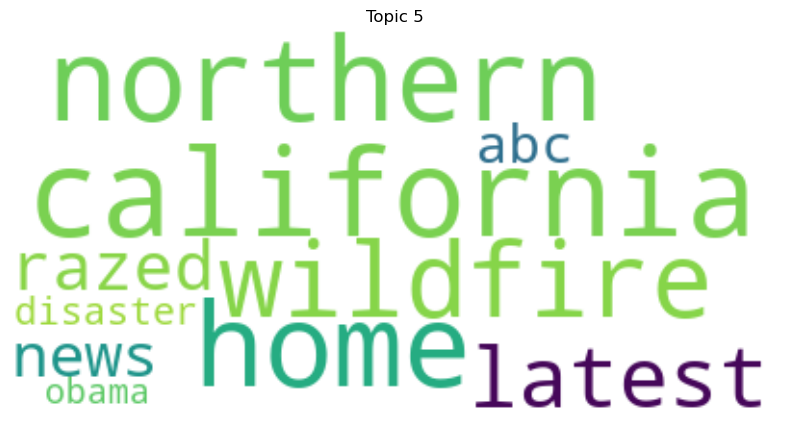

In [87]:

# Get the feature names from tfidf vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get the topics and their top 10 words for NMF
nmf_topics = [[(feature_names[i], topic[i]) for i in topic.argsort()[:-11:-1]] for topic in nmf.components_]

for i, topic in enumerate(nmf_topics):
    wc = WordCloud(background_color="white", max_words=2000)
    wc.generate_from_frequencies(dict(topic))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Topic {i+1}')
    plt.show()

### Evaluating the model

In [88]:
nmf_topics = [[feature_names[i] for i in topic.argsort()[:-11:-1]] for topic in nmf.components_]


In [89]:
dictionary = Dictionary(data_train['processed_text'].map(lambda x: x.split()))

In [90]:
corpus = [dictionary.doc2bow(text.split()) for text in data_train['processed_text']]


In [91]:
mf_topics = [[feature_names[i] for i in topic.argsort()[:-10 - 1:-1]] for topic in nmf.components_]

In [92]:
nmf_coherence = CoherenceModel(topics=nmf_topics, texts=df_topic_modelling['processed_text'].map(lambda x: x.split()), dictionary=dictionary, coherence='c_v').get_coherence()
print('NMF Coherence: ', nmf_coherence)

NMF Coherence:  0.5982137000722323


### 3. Which topics are most important or prevalent?


In [97]:
feature_names = vectorizer.get_feature_names_out()
word_importance = {}
for topic_idx, topic in enumerate(nmf_model.components_):
    word_importance[topic_idx] = {feature_names[i]: topic[i] for i in topic.argsort()[:-11:-1]}

NameError: name 'nmf_model' is not defined

In [ ]:
sns.histplot(topic_counts, bins=num_topics, kde=False)
plt.xlabel('Topic Index')
plt.ylabel('Number of Documents')
plt.title('Topic Distribution in the Corpus')
plt.show()

## References